In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import result_utils
import os; print(os.environ['LD_LIBRARY_PATH'])

/net/lem/data2/regt/MultiNest/lib:/software/rhel9-amd/lib64:


In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'
color_A_eq = mpl.colors.LinearSegmentedColormap.from_list('', [color_A, 'w'])(0.3)
color_B_eq = mpl.colors.LinearSegmentedColormap.from_list('', [color_B, 'w'])(0.3)

cmap_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_A])
env_colors_A = cmap_A([0,1/4,2/4,3/4,1])
env_colors_A[:,3] = 0.5; env_colors_A[0,3] = 0.0

cmap_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_B])
env_colors_B = cmap_B([0,1/4,2/4,3/4,1])
env_colors_B[:,3] = 0.5; env_colors_B[0,3] = 0.0

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

path = '/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs'
A = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_8/test_')
B = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_8/test_')
A_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_A_ret_5/test_')
B_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_B_ret_7/test_')

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_8/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_8/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_8/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_8/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_5/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_5/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_7/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_7/test_.txt


In [3]:
A_eq.compare_evidence(A, names=('A_eq', 'A'))
B_eq.compare_evidence(B, names=('B_eq', 'B'))

A_eq vs. A: B=7.52e+07, "sigma"=6.35, ln(B)=18.14, log10(B)=7.88
A_eq vs. A: AIC=-3.67, BIC=-20.31, BPICS=-4.74

B_eq vs. B: B=2.29e+52, "sigma"=15.71, ln(B)=120.56, log10(B)=52.36
B_eq vs. B: AIC=-289.03, BIC=-305.67, BPICS=-287.41



In [4]:
def get_chemical_ratios(Res, mean_along_axis=None, P=0.4):
    
    # Load the chemistry module
    Res.load_components(['Chem'])

    m_set = Res.model_settings[0]
    VMRs = Res.Chem[m_set].VMRs_posterior

    posterior_shape = (Res.posterior.shape[0], len(Res.Chem[m_set].pressure))

    chem_ratios = {}
    chem_ratios['C/O'] = (
        (VMRs.get('12CO',0.)+VMRs.get('CH4',0.)+VMRs.get('13CO',0.)) / 
        (VMRs.get('12CO',0.)+VMRs.get('13CO',0.)+VMRs.get('H2O',0.))
    )

    # Isotope ratios
    chem_ratios['12CO/13CO'] = VMRs.get('12CO',0.) / VMRs.get('13CO',np.inf)
    chem_ratios['C16O/C18O'] = VMRs.get('12CO',0.) / VMRs.get('C18O',np.inf)
    chem_ratios['C16O/C17O'] = VMRs.get('12CO',0.) / VMRs.get('C17O',np.inf)
    
    chem_ratios['H2O/HDO'] = VMRs.get('H2O',0.) / VMRs.get('HDO',np.inf)
    chem_ratios['H2(16)O/H2(18)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(18)O',np.inf)
    chem_ratios['H2(16)O/H2(17)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(17)O',np.inf)

    chem_ratios['12CH4/13CH4'] = VMRs.get('CH4',0.) / VMRs.get('13CH4',np.inf)
    chem_ratios['14NH3/15NH3'] = VMRs.get('NH3',0.) / VMRs.get('15NH3',np.inf)
    
    # Absolute abundances
    abs_abund = {}
    solar = {
        'C':10**8.46, 'N':10**7.83, 'O':10**8.69, 'F':10**4.40, 'S':10**7.12, 'H':10**12.0, 
        'Na': 10**6.22, 'K': 10**5.07, 'Fe': 10**7.46, 
        }

    VMR_H = (
        VMRs.get('H2',0.)*2 + VMRs.get('H2O',0.)*2 + VMRs.get('CH4',0.)*4 + \
        VMRs.get('NH3',0.)*3 + VMRs.get('H2S',0.)*2 + VMRs.get('HF',0.)*1 + \
        VMRs.get('FeH',0.)*1 
    )
    VMR_C = VMRs.get('12CO',0.) + VMRs.get('CH4',0.) + VMRs.get('13CO',0.)
    VMR_N = VMRs.get('NH3',0.)
    VMR_O = VMRs.get('H2O',0.) + VMRs.get('12CO',0.) + VMRs.get('13CO',0.)
    VMR_F = VMRs.get('HF',0.)
    VMR_S = VMRs.get('H2S',0.)
    
    VMR_Na = VMRs.get('Na',0.)
    VMR_K = VMRs.get('K',0.)
    VMR_Fe = VMRs.get('Fe',0.) + VMRs.get('FeH',0.)

    abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
    abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
    abs_abund['O/H'] = np.log10(VMR_O/VMR_H) - np.log10(solar['O']/solar['H'])
    abs_abund['F/H'] = np.log10(VMR_F/VMR_H) - np.log10(solar['F']/solar['H'])
    abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])
    abs_abund['Na/H'] = np.log10(VMR_Na/VMR_H) - np.log10(solar['Na']/solar['H'])
    abs_abund['K/H'] = np.log10(VMR_K/VMR_H) - np.log10(solar['K']/solar['H'])
    abs_abund['Fe/H'] = np.log10(VMR_Fe/VMR_H) - np.log10(solar['Fe']/solar['H'])

    # abs_abund['(C+O)/H'] = (
    #     np.log10((VMR_C+VMR_O)/VMR_H) - np.log10((solar['C']+solar['O'])/solar['H'])
    # )
    # abs_abund['M/H'] = (
    #     np.log10((VMR_C+VMR_N+VMR_O+VMR_F+VMR_S+VMR_Na+VMR_K+VMR_Fe)/VMR_H) - \
    #     np.log10((
    #         solar['C']+solar['N']+solar['O']+solar['F']+solar['S']+solar['Na']+solar['K']+solar['Fe']
    #         )/solar['H'])
    # )
            
    if mean_along_axis is not None:

        idx_P = np.argmin(np.abs(Res.Chem[m_set].pressure-P))
        keys = list(chem_ratios.keys())

        for key in keys:
            if isinstance(chem_ratios[key], float):
                chem_ratios[key] = np.ones(posterior_shape) * chem_ratios[key]

            #chem_ratios[key] = np.mean(chem_ratios[key], axis=mean_along_axis)
            chem_ratios[key] = chem_ratios[key][:,idx_P]

            # For chemical equilibrium retrievals
            idx = Res.ParamTable.get(key, key='idx_free')
            if idx is not None:
                print(idx, key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = Res.posterior[:,idx]
            
            idx = Res.ParamTable.get(f'log_{key.split("/")[-1]}_ratio', key='idx_free')
            if idx is not None:
                print(idx, 'log_'+key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = 10**Res.posterior[:,idx]

        for key in abs_abund.keys():
            if isinstance(abs_abund[key], float):
                abs_abund[key] = np.ones(posterior_shape) * abs_abund[key]

            #abs_abund[key] = np.mean(abs_abund[key], axis=mean_along_axis)
            abs_abund[key] = abs_abund[key][:,idx_P]

        idx_P = np.argsort(np.abs(Res.Chem[m_set].pressure-P))[:4]
        from scipy.interpolate import interp1d
        for key, VMR in VMRs.items():
            f = interp1d(np.log10(Res.Chem[m_set].pressure[idx_P]), np.log10(VMR[:,idx_P]))
            # Interpolate the VMRs to the desired pressure
            abs_abund[key] = 10**f(np.log10(P))
            # abs_abund[key] = np.mean(VMR[:,idx_P])

    return chem_ratios, abs_abund

chem_ratios_A, abs_abund_A = get_chemical_ratios(A, mean_along_axis=-1)
chem_ratios_B, abs_abund_B = get_chemical_ratios(B, mean_along_axis=-1)

chem_ratios_A_eq, abs_abund_A_eq = get_chemical_ratios(A_eq, mean_along_axis=-1)
chem_ratios_B_eq, abs_abund_B_eq = get_chemical_ratios(B_eq, mean_along_axis=-1)

def get_absolute_abundances_eqchem(Res, abs_abund={}):
    
    for el_i in ['C', 'N', 'O', 'F', 'S']:
        idx_free = Res.ParamTable.get(f'alpha_{el_i}', key='idx_free')
        abs_abund[f'{el_i}/H'] = Res.posterior[:,idx_free]

    CO = 10**(abs_abund.get('C/H')+8.46) / 10**(abs_abund.get('O/H')+8.69)
    return abs_abund, CO

chem_ratios_A_eq['C/O_mean'] = chem_ratios_A_eq['C/O'].copy()
abs_abund_A_eq, chem_ratios_A_eq['C/O'] = get_absolute_abundances_eqchem(A_eq, abs_abund_A_eq)

chem_ratios_B_eq['C/O_mean'] = chem_ratios_B_eq['C/O'].copy()
abs_abund_B_eq, chem_ratios_B_eq['C/O'] = get_absolute_abundances_eqchem(B_eq, abs_abund_B_eq)

/var/tmp/regt/ipykernel_2749559/1950963870.py:56: RuntimeWarning: divide by zero encountered in log10
  abs_abund['Na/H'] = np.log10(VMR_Na/VMR_H) - np.log10(solar['Na']/solar['H'])
/var/tmp/regt/ipykernel_2749559/1950963870.py:57: RuntimeWarning: divide by zero encountered in log10
  abs_abund['K/H'] = np.log10(VMR_K/VMR_H) - np.log10(solar['K']/solar['H'])
/var/tmp/regt/ipykernel_2749559/1950963870.py:58: RuntimeWarning: divide by zero encountered in log10
  abs_abund['Fe/H'] = np.log10(VMR_Fe/VMR_H) - np.log10(solar['Fe']/solar['H'])


14 log_12CO/13CO
15 log_C16O/C18O
16 log_C16O/C17O
17 log_H2(16)O/H2(18)O
18 log_H2(16)O/H2(17)O
14 log_12CO/13CO
15 log_C16O/C18O
16 log_C16O/C17O
17 log_H2(16)O/H2(18)O
18 log_H2(16)O/H2(17)O


In [5]:
A_J = result_utils.RetrievalResults(f'{path}/J_A_ret_22_1column_n1000/test_')
B_J = result_utils.RetrievalResults(f'{path}/J_B_ret_62_1column_n1000/test_')

A_J.model_settings = ['J1226_1']; B_J.model_settings = ['J1226_1']

A_J.load_components(['Chem'])
B_J.load_components(['Chem'])

chem_ratios_A_J, abs_abund_A_J = get_chemical_ratios(A_J, mean_along_axis=-1, P=10**(np.log10(7.)-0.2))
chem_ratios_B_J, abs_abund_B_J = get_chemical_ratios(B_J, mean_along_axis=-1, P=10**(np.log10(7.)+0.2))

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_A_ret_22_1column_n1000/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_A_ret_22_1column_n1000/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_B_ret_62_1column_n1000/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_B_ret_62_1column_n1000/test_.txt


/var/tmp/regt/ipykernel_2749559/1950963870.py:51: RuntimeWarning: divide by zero encountered in log10
  abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
/var/tmp/regt/ipykernel_2749559/1950963870.py:52: RuntimeWarning: divide by zero encountered in log10
  abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
/var/tmp/regt/ipykernel_2749559/1950963870.py:55: RuntimeWarning: divide by zero encountered in log10
  abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])


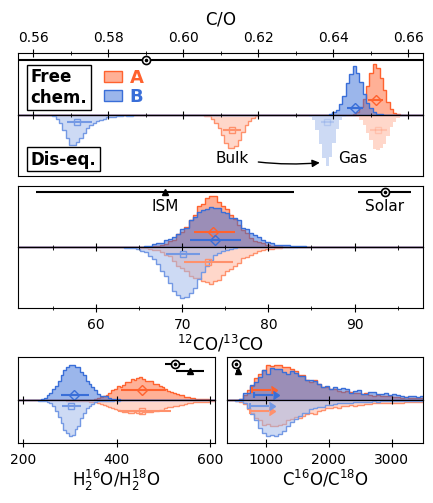

In [6]:
def plot_errorbar(ax, posterior, y, q, transform=None, ms=3.5, fmt='s', **kwargs):

    x = np.median(posterior)
    xerr = np.quantile(posterior, q=q) - x
    xerr = np.abs(xerr)[:,None]

    if transform is None:
        transform = ax.get_xaxis_transform()

    if xerr.shape[0] == 1:
        ax.errorbar(
            x-xerr, y, yerr=0.07, transform=transform, fmt='', lw=1.5, ms=ms, capsize=0, xlolims=True, **kwargs,
            )
    else:
        ax.errorbar(
            x, y, xerr=xerr, transform=transform, fmt=fmt, lw=1.5, ms=ms, capsize=0, **kwargs,
            )

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    histtype='stepfilled', fc=env_colors_A[-1], ec=color_A, lw=lw_m, bottom=0, density=True,
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_B[-1]
hist_kwargs_B['ec'] = color_B

hist_kwargs_A_eq = hist_kwargs_A.copy()
hist_kwargs_A_eq['ec'] = color_A_eq
hist_kwargs_A_eq['fc'] = env_colors_A[2]
# hist_kwargs_A_eq['hatch'] = '\\\\'

hist_kwargs_B_eq = hist_kwargs_B.copy()
hist_kwargs_B_eq['ec'] = color_B_eq
hist_kwargs_B_eq['fc'] = env_colors_B[2]
# hist_kwargs_B_eq['hatch'] = '//'

hist_kwargs_gas = hist_kwargs_A.copy()
hist_kwargs_gas.pop('fc', None)
hist_kwargs_gas['ec'] = 'none'
# hist_kwargs_gas['lw'] = 0.8

hist_info = {
    'C/O':             (120, [0.556, 0.664]), 
    '12CO/13CO':       (100, [51,98]), 
    'H2(16)O/H2(18)O': (70, [190,610]), 
    'C16O/C18O':       (50, [380,3500]), 
}

fig = plt.figure(figsize=(4.5,5.))
gs = fig.add_gridspec(
    # nrows=5, ncols=2, hspace=0., wspace=0.08, height_ratios=[1,1,0.2,1,1],
    nrows=8, ncols=2, hspace=0., wspace=0.06, height_ratios=[1.,1.,0.15,1.,1.,0.8,0.7,0.7],
)

ax_1 = np.array([
    fig.add_subplot(gs[0,:]),fig.add_subplot(gs[3,:]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[6,1])
    ])
ax_2 = np.array([
    fig.add_subplot(gs[1,:]),fig.add_subplot(gs[4,:]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[7,1])
    ]) 

ax_1[0].set_xticks(np.arange(0.55,0.67,0.01), minor=True)
ax_2[0].set_xticks(np.arange(0.55,0.67,0.01), minor=True)
ax_1[1].set_xticks(np.arange(50,100,5), minor=True)
ax_2[1].set_xticks(np.arange(50,100,5), minor=True)

for i, key in enumerate(hist_info.keys()):
    bins, hist_range = hist_info[key]

    handle_A = ax_1[i].hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
    handle_B = ax_1[i].hist(chem_ratios_B[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B)
    handle_A = ax_2[i].hist(chem_ratios_A_eq[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq)
    handle_B = ax_2[i].hist(chem_ratios_B_eq[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq)

    if key == 'C/O':
        ax_2[i].hist(chem_ratios_A_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_A[2], **hist_kwargs_gas)
        ax_2[i].hist(chem_ratios_B_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_B[2], **hist_kwargs_gas)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[f'{key}_mean'], y=0.76, q=result_utils.q[[2,4]], color=color_A_eq, alpha=0.3, ms=5, mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_B_eq[f'{key}_mean'], y=0.88, q=result_utils.q[[2,4]], color=color_B_eq, alpha=0.3, ms=5, mfc='none')

    if key != 'C16O/C18O':
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[2,4]], color=color_A, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[2,4]], color=color_B, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[2,4]], color=color_A_eq, ms=5, mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[2,4]], color=color_B_eq, ms=5, mfc='none')
    else:
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[1]], color=color_A, xerr=300, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[1]], color=color_B, xerr=300, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[1]], color=color_A_eq, xerr=300, ms=5, mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[1]], color=color_B_eq, xerr=300, ms=5, mfc='none')

    ylim = ax_1[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.15]
    ax_1[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')

    ylim = ax_2[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.15]
    ax_2[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')
    ax_2[i].yaxis.set_inverted(True)

ax_1[0].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, direction='inout', length=6)
ax_1[0].tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, labelbottom=False, direction='inout', length=3)
ax_2[0].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=6)
ax_2[0].tick_params(axis='x', which='minor', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=3)

ax_1[1].tick_params(axis='x', bottom=False, labelbottom=False)
ax_2[1].tick_params(axis='x', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=6)
ax_2[1].tick_params(axis='x', which='minor', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=3)

ax_1[2].tick_params(axis='x', bottom=False, labelbottom=False)
ax_1[3].tick_params(axis='x', bottom=False, labelbottom=False)
ax_2[2].tick_params(axis='x', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=6)
ax_2[3].tick_params(axis='x', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=6)

ax_1[0].set_xlabel(r'$\mathrm{C/O}$', fontsize=12, labelpad=5)
ax_2[1].set_xlabel(r'$\mathrm{^{12}CO/^{13}CO}$', fontsize=12, labelpad=1.0)
ax_2[2].set_xlabel(r'$\mathrm{H_2^{16}O/H_2^{18}O}$', fontsize=12, labelpad=1.0)
ax_2[3].set_xlabel(r'$\mathrm{C^{16}O/C^{18}O}$', fontsize=12, labelpad=1.0)

ax_1[0].xaxis.set_label_position('top')

ann_kwargs = dict(xycoords=ax_2[0].get_xaxis_transform(), ha='center', va='center', fontsize=11)
arrowprops = dict(
    arrowstyle='-|>,head_width=0.2,head_length=0.4', shrinkB=24, shrinkA=5, connectionstyle='arc3,rad=0.1', lw=1, color='k'
)
xy = (np.mean([np.median(chem_ratios_A_eq['C/O_mean']),np.median(chem_ratios_B_eq['C/O_mean'])]),0.15)
xytext = (np.median(chem_ratios_A_eq['C/O']),0.3)
ax_2[0].annotate('Gas', xy=xy, xytext=(xy[0],xytext[1]), **ann_kwargs)
ax_2[0].annotate('Bulk', xy=(xy[0],xytext[1]), xytext=xytext, **ann_kwargs, arrowprops=arrowprops)

ax_1[0].legend(
    loc='lower center', bbox_to_anchor=(0.26,0.), labelspacing=0.05, handlelength=1.0, handleheight=0.5, 
    handletextpad=0.4, borderpad=0., labelcolor=[color_A, color_B], prop={'weight':'bold', 'size':13}, frameon=False, 
)

def add_odot(ax, x, y, color='k', ms=5, mec='w', transform=None):
    if transform is None:
        transform = ax.get_xaxis_transform()
    ax.plot([x], [y], 'o', transform=transform, ms=ms, c=color)
    ax.plot([x], [y], 'o', transform=transform, ms=ms*3/5, mfc='none', mec=mec)

kwargs = dict(lw=1.5, ms=5, capsize=0, c='k')
ann_kwargs = dict(ha='center', va='top', fontsize=11)
y = 0.89; ydiff = 0.1
ax_1[0].errorbar(0.59, y, xerr=0.08, transform=ax_1[0].get_xaxis_transform(), fmt='', **kwargs)

ax_1[1].errorbar(68, y, xerr=15, transform=ax_1[1].get_xaxis_transform(), fmt='^', **kwargs)
ax_1[1].errorbar(93.5, y, xerr=3.1, transform=ax_1[1].get_xaxis_transform(), fmt='', **kwargs)
ax_1[1].annotate('Solar', xy=(93.5,y-ydiff), xycoords=ax_1[1].get_xaxis_transform(), **ann_kwargs)
ax_1[1].annotate('ISM', xy=(68,y-ydiff), xycoords=ax_1[1].get_xaxis_transform(), **ann_kwargs)
add_odot(ax_1[0], 0.59, y, color='k', ms=6, mec='w')
add_odot(ax_1[1], 93.5, y, color='k', ms=6, mec='w')

y -= 0.05
ax_1[2].errorbar(525, y, xerr=21, transform=ax_1[2].get_xaxis_transform(), fmt='', **kwargs) # (Solar) Lyons et al. (2018)
# ax_1[2].errorbar(395, y, xerr=56, transform=ax_1[2].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)
ax_1[2].errorbar(557, y-0.15, xerr=30, transform=ax_1[2].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)

ax_1[3].errorbar(525, y, xerr=21, transform=ax_1[3].get_xaxis_transform(), fmt='', **kwargs) # (Solar) Lyons et al. (2018)
# ax_1[3].errorbar(395, y, xerr=56, transform=ax_1[3].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)
ax_1[3].errorbar(557, y-0.15, xerr=30, transform=ax_1[3].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)

add_odot(ax_1[2], 525, y, color='k', ms=6, mec='w')
add_odot(ax_1[3], 525, y, color='k', ms=6, mec='w')

ann_kwargs = dict(
    xycoords='axes fraction', fontsize=12, ha='left', va='center', fontweight='bold', 
    bbox={'boxstyle':'square,pad=0.2', 'ec':'k', 'fc':'w', 'alpha':1}
)
ax_1[0].annotate('Free\nchem.', xy=(0.03, 0.45), **ann_kwargs)
ax_2[0].annotate('Dis-eq.', xy=(0.03, 0.28), **ann_kwargs)

plt.subplots_adjust(left=0.05, bottom=0.11, top=0.89, right=0.95)
plt.savefig(f'./plots/K_band_chem_ratios.pdf')
plt.show()

In [ ]:
# # Oxygen Sequestration (%)
# result_utils.latex_format(
#     (chem_ratios_A_eq['C/O_mean']-chem_ratios_A_eq['C/O'])/chem_ratios_A_eq['C/O_mean'] * 100, 
#     (chem_ratios_B_eq['C/O_mean']-chem_ratios_B_eq['C/O'])/chem_ratios_B_eq['C/O_mean'] * 100
# )

# result_utils.latex_format(chem_ratios_A_eq['C/O'], chem_ratios_B_eq['C/O'], decimals=3)

result_utils.latex_format(chem_ratios_A['C/O'], chem_ratios_B['C/O'], decimals=3)
result_utils.latex_format(chem_ratios_A['12CO/13CO'], chem_ratios_B['12CO/13CO'], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[[4,2]], decimals=0)
result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[0], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
result_utils.latex_format(chem_ratios_A['H2(16)O/H2(18)O'], chem_ratios_B['H2(16)O/H2(18)O'], decimals=0)

$6.00^{+0.16}_{-0.17}$ & $10.49^{+0.23}_{-0.51}$ \\
$0.651^{+0.002}_{-0.002}$ & $0.646^{+0.002}_{-0.002}$ \\
$74^{+2}_{-2}$ & $74^{+3}_{-3}$ \\
$>785$ & $>815$ \\
$454^{+52}_{-45}$ & $309^{+31}_{-27}$ \\


In [8]:
lolim = []
uplim = ['log_H2(17)O', 'log_C18O', 'log_C17O', 'log_CO2', 'log_HCN']
# result_utils.q[1]
indices = [
    ('log_H2O', 3), 
    'log_H2(18)O', 
    'log_H2(17)O', 
    ('log_12CO', 3), 
    'log_13CO', 
    'log_C18O', 
    'log_C17O', 
    'log_CH4', 
    'log_NH3', 
    'log_H2S', 
    'log_HF', 
    'log_CO2', 
    'log_HCN', 
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    ('dlnT_dlnP_1', 3),
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx_free = A.ParamTable.get(item, key='idx_free')
    idx_eq   = A_eq.ParamTable.get(item, key='idx_free')

    if idx_free is not None:
        post_A = A.posterior[:,idx_free]
        post_B = B.posterior[:,idx_free]
    else:
        post_A = abs_abund_A.get(item.replace('log_',''))
        post_B = abs_abund_B.get(item.replace('log_',''))
        if not isinstance(post_A, np.ndarray):
            raise ValueError(f'Item {item} not found in A or B.')
        if item.startswith('log_'):
            post_A = np.log10(post_A); post_B = np.log10(post_B)

    if idx_eq is not None:
        post_A_eq = A_eq.posterior[:,idx_eq]
        post_B_eq = B_eq.posterior[:,idx_eq]
    else:
        post_A_eq = abs_abund_A_eq.get(item.replace('log_',''))
        post_B_eq = abs_abund_B_eq.get(item.replace('log_',''))
        if not isinstance(post_A_eq, np.ndarray):
            raise ValueError(f'Item {item} not found in A_eq or B_eq.')
        if item.startswith('log_'):
            post_A_eq = np.log10(post_A_eq); post_B_eq = np.log10(post_B_eq)
    
    q = result_utils.q[[4,2]]  # 16th and 84th percentiles
    if item in lolim:
        q = [result_utils.q[1]]
    if item in uplim:
        q = [result_utils.q[5]]

    print(item)
    result_utils.latex_format(post_A, post_A_eq, post_B, post_B_eq, decimals=decimals, q=q)
    if len(q) == 1:
        result_utils.latex_format(post_A, post_A_eq, post_B, post_B_eq, decimals=decimals)

log_H2O
$-3.402^{+0.012}_{-0.012}$ & $-3.397^{+0.016}_{-0.015}$ & $-3.541^{+0.012}_{-0.012}$ & $-3.463^{+0.009}_{-0.010}$ \\
log_H2(18)O
$-6.06^{+0.05}_{-0.05}$ & $-6.06^{+0.06}_{-0.06}$ & $-6.03^{+0.04}_{-0.04}$ & $-5.94^{+0.03}_{-0.03}$ \\
log_H2(17)O
$<-7.53$ & $<-7.01$ & $<-7.00$ & $<-6.80$ \\
$-10.63^{+1.86}_{-1.87}$ & $-7.79^{+0.42}_{-0.37}$ & $-10.23^{+2.10}_{-2.12}$ & $-7.49^{+0.39}_{-0.42}$ \\
log_12CO
$-3.146^{+0.012}_{-0.012}$ & $-3.140^{+0.015}_{-0.014}$ & $-3.309^{+0.012}_{-0.012}$ & $-3.245^{+0.009}_{-0.010}$ \\
log_13CO
$-5.01^{+0.02}_{-0.02}$ & $-5.01^{+0.02}_{-0.02}$ & $-5.18^{+0.02}_{-0.02}$ & $-5.10^{+0.02}_{-0.02}$ \\
log_C18O
$<-6.04$ & $<-6.02$ & $<-6.22$ & $<-6.13$ \\
$-6.44^{+0.25}_{-3.03}$ & $-6.30^{+0.16}_{-0.23}$ & $-6.77^{+0.39}_{-3.07}$ & $-6.34^{+0.11}_{-0.14}$ \\
log_C17O
$<-6.42$ & $<-6.31$ & $<-6.46$ & $<-6.36$ \\
$-9.34^{+2.33}_{-2.58}$ & $-6.82^{+0.32}_{-0.52}$ & $-8.92^{+2.05}_{-2.82}$ & $-6.73^{+0.22}_{-0.30}$ \\
log_CH4
$-5.22^{+0.02}_{-0.02}$ & $-

In [9]:
print('C/O ratio:')
result_utils.latex_format(
    chem_ratios_A['C/O'], chem_ratios_A_eq['C/O'], chem_ratios_B['C/O'], chem_ratios_B_eq['C/O'], decimals=3
    )

for item, decimals in [('C/H',3), ('O/H',3), ('N/H',2), ('S/H',2), ('F/H',2)]:
    print(item)
    idx = A_eq.ParamTable.get('alpha_'+item.replace('/H',''), key='idx_free')
    result_utils.latex_format(
        abs_abund_A[item], A_eq.posterior[:,idx], abs_abund_B['C/H'], B_eq.posterior[:,idx], decimals=decimals
        )

for item in ['12CO/13CO', 'C16O/C18O', 'C16O/C17O', 'H2(16)O/H2(18)O', 'H2(16)O/H2(17)O']:
    print(item)

    if ('17' in item) or ('18' in item):
        result_utils.latex_format(
            np.log10(chem_ratios_A[item]), np.log10(chem_ratios_A_eq[item]), 
            np.log10(chem_ratios_B[item]), np.log10(chem_ratios_B_eq[item]), decimals=2, q=result_utils.q[2]
            )

    result_utils.latex_format(
        np.log10(chem_ratios_A[item]), np.log10(chem_ratios_A_eq[item]), 
        np.log10(chem_ratios_B[item]), np.log10(chem_ratios_B_eq[item]), decimals=2
        )
print()
idx_Kzz = A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')
result_utils.latex_format(A_eq.posterior[:,idx_Kzz], B_eq.posterior[:,idx_Kzz], decimals=2)

C/O ratio:
$0.651^{+0.002}_{-0.002}$ & $0.613^{+0.002}_{-0.002}$ & $0.646^{+0.002}_{-0.002}$ & $0.572^{+0.004}_{-0.003}$ \\
C/H
$0.173^{+0.012}_{-0.012}$ & $0.169^{+0.015}_{-0.014}$ & $0.015^{+0.012}_{-0.012}$ & $0.069^{+0.009}_{-0.010}$ \\
O/H
$0.129^{+0.012}_{-0.012}$ & $0.151^{+0.015}_{-0.013}$ & $0.015^{+0.012}_{-0.012}$ & $0.082^{+0.009}_{-0.010}$ \\
N/H
$-2.21^{+0.03}_{-0.03}$ & $-0.43^{+0.09}_{-0.10}$ & $0.01^{+0.01}_{-0.01}$ & $-0.07^{+0.04}_{-0.04}$ \\
S/H
$0.30^{+0.03}_{-0.03}$ & $0.31^{+0.03}_{-0.03}$ & $0.01^{+0.01}_{-0.01}$ & $0.25^{+0.02}_{-0.02}$ \\
F/H
$0.07^{+0.02}_{-0.02}$ & $0.07^{+0.03}_{-0.03}$ & $0.01^{+0.01}_{-0.01}$ & $-0.02^{+0.02}_{-0.02}$ \\
12CO/13CO
$1.87^{+0.01}_{-0.01}$ & $1.86^{+0.02}_{-0.02}$ & $1.87^{+0.02}_{-0.02}$ & $1.85^{+0.01}_{-0.01}$ \\
C16O/C18O
$>3.04$ & $>2.99$ & $>3.08$ & $>2.97$ \\


$3.29^{+3.04}_{-0.25}$ & $3.15^{+0.23}_{-0.16}$ & $3.46^{+3.08}_{-0.38}$ & $3.09^{+0.14}_{-0.11}$ \\
C16O/C17O
$>3.86$ & $>3.35$ & $>3.56$ & $>3.26$ \\
$6.19^{+2.58}_{-2.33}$ & $3.68^{+0.52}_{-0.32}$ & $5.61^{+2.82}_{-2.04}$ & $3.48^{+0.30}_{-0.22}$ \\
H2(16)O/H2(18)O
$>2.61$ & $>2.60$ & $>2.45$ & $>2.45$ \\
$2.66^{+0.05}_{-0.05}$ & $2.66^{+0.06}_{-0.05}$ & $2.49^{+0.04}_{-0.04}$ & $2.48^{+0.03}_{-0.03}$ \\
H2(16)O/H2(17)O
$>5.37$ & $>3.97$ & $>4.58$ & $>3.63$ \\
$7.23^{+1.87}_{-1.85}$ & $4.39^{+0.36}_{-0.42}$ & $6.69^{+2.12}_{-2.11}$ & $4.03^{+0.42}_{-0.39}$ \\

$8.70^{+0.25}_{-0.21}$ & $8.17^{+0.12}_{-0.09}$ \\


In [10]:
indices = [
    # ('C/O', 3), 
    # ('Fe/H', 2), 
    'alpha_C',
    'alpha_O', 
    'alpha_N', 
    'alpha_S',
    'alpha_F',
    'log_13CO_ratio', 
    'log_C18O_ratio',
    'log_C17O_ratio',
    'log_H2(18)O_ratio',
    'log_H2(17)O_ratio',
    ('log_Kzz_chem',1),
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    'dlnT_dlnP_1', 
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx_free = A.ParamTable.get(item, key='idx_free')
    idx_eq   = A_eq.ParamTable.get(item, key='idx_free')
    print(item)
    result_utils.latex_format(A_eq.posterior[:,idx_eq], B_eq.posterior[:,idx_eq], decimals=decimals)

alpha_C
$0.17^{+0.02}_{-0.01}$ & $0.07^{+0.01}_{-0.01}$ \\
alpha_O
$0.15^{+0.01}_{-0.01}$ & $0.08^{+0.01}_{-0.01}$ \\
alpha_N
$-0.43^{+0.09}_{-0.10}$ & $-0.07^{+0.04}_{-0.04}$ \\
alpha_S
$0.31^{+0.03}_{-0.03}$ & $0.25^{+0.02}_{-0.02}$ \\
alpha_F
$0.07^{+0.03}_{-0.03}$ & $-0.02^{+0.02}_{-0.02}$ \\
log_13CO_ratio


$1.86^{+0.02}_{-0.02}$ & $1.85^{+0.01}_{-0.01}$ \\
log_C18O_ratio
$3.15^{+0.23}_{-0.16}$ & $3.09^{+0.14}_{-0.11}$ \\
log_C17O_ratio
$3.68^{+0.52}_{-0.32}$ & $3.48^{+0.30}_{-0.22}$ \\
log_H2(18)O_ratio
$2.66^{+0.06}_{-0.05}$ & $2.48^{+0.03}_{-0.03}$ \\
log_H2(17)O_ratio
$4.39^{+0.36}_{-0.42}$ & $4.03^{+0.42}_{-0.39}$ \\
log_Kzz_chem
$8.7^{+0.2}_{-0.2}$ & $8.2^{+0.1}_{-0.1}$ \\
--------------------
log_g
$4.96^{+0.02}_{-0.02}$ & $4.82^{+0.01}_{-0.01}$ \\
vsini
$14.80^{+0.03}_{-0.03}$ & $25.34^{+0.04}_{-0.04}$ \\
rv
$17.21^{+0.02}_{-0.02}$ & $19.75^{+0.02}_{-0.02}$ \\
--------------------
dlnT_dlnP_0
$0.18^{+0.07}_{-0.05}$ & $0.28^{+0.04}_{-0.05}$ \\
dlnT_dlnP_1
$0.23^{+0.01}_{-0.01}$ & $0.25^{+0.01}_{-0.01}$ \\
dlnT_dlnP_2
$0.052^{+0.002}_{-0.001}$ & $0.057^{+0.004}_{-0.003}$ \\
dlnT_dlnP_3
$0.29^{+0.02}_{-0.02}$ & $0.26^{+0.01}_{-0.01}$ \\
dlnT_dlnP_4
$0.13^{+0.10}_{-0.08}$ & $0.12^{+0.07}_{-0.06}$ \\
log_P_phot
$-0.19^{+0.03}_{-0.04}$ & $-0.19^{+0.02}_{-0.02}$ \\
T_phot
$1228^{+10}_{-1

# Abundance profiles in dis-equilibrium

In [11]:
def plot_envelopes(ax, y, x, x_indices=[[2,4]], fc=[], median_kwargs={}, **fill_betweenx_kwargs):
    
    patch = None
    for i, (idx_l, idx_u) in enumerate(x_indices):
        patch = ax.fill_betweenx(
            y=y, x1=x[idx_l], x2=x[idx_u], fc=fc[i], **fill_betweenx_kwargs
            )
    
    line = None
    if len(median_kwargs) > 0:
        idx_m = median_kwargs.get('idx', 3)
        median_kwargs.pop('idx', None)

        line, = ax.plot(x[idx_m], y, **median_kwargs)
    
    return (line, patch, line)

def plot_VMR_envelope(ax, Chem, species, log_g_norm_factor=None, median_kwargs={}, **fill_betweenx_kwargs):

    if log_g_norm_factor is not None:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species]*log_g_norm_factor)
    else:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    plot_envelopes(
        ax, Chem.pressure, VMR_q, median_kwargs=median_kwargs, **fill_betweenx_kwargs, 
        )

def plot_VMR_errorbar(ax, Chem, species, log_g_norm_factor=None, y=1, x_indices=[[0,6],[1,5],[2,4]], **errorbar_kwargs):

    if log_g_norm_factor is not None:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species]*log_g_norm_factor)
    else:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    
    VMR_q = np.median(VMR_q, axis=-1)
    
    x = VMR_q[3]
    xerr = np.array([VMR_q[x_indices[i]] for i in range(len(x_indices))])
    xerr = np.abs(xerr-x).T

    x = np.repeat(x, len(x_indices))
    y = np.repeat(y, len(x_indices))
    ax.errorbar(x, y, xerr=xerr, **errorbar_kwargs)

def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)
log_g_A_J = get_log_g_posterior(A_J)
log_g_B_J = get_log_g_posterior(B_J)

log_g_norm_factor_A = 10**(4.96-log_g_A)
log_g_norm_factor_B = 10**(4.88-log_g_B)

log_g_norm_factor_A_eq = 10**(4.96-log_g_A_eq)
log_g_norm_factor_B_eq = 10**(4.88-log_g_B_eq)

log_g_norm_factor_A_J = 10**(4.96-log_g_A_J)
log_g_norm_factor_B_J = 10**(4.88-log_g_B_J)

/var/tmp/regt/ipykernel_2749559/4134042468.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=0)
/var/tmp/regt/ipykernel_2749559/4134042468.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), rotation=0)


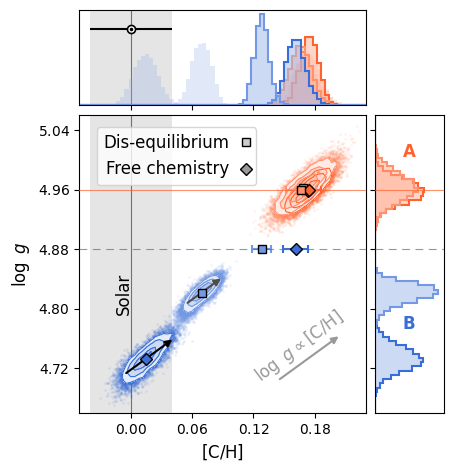

In [93]:
species = 'C/H'

ylim = (4.66,5.06)
# xlim = -3.21 + np.array([-1,1])*np.diff(ylim)/2
# xlim = (-3.37, -3.05)
xlim = (-0.05,0.23)

post_A = np.array([abs_abund_A[species], log_g_A]).T
post_A_eq = np.array([abs_abund_A_eq[species], log_g_A_eq]).T
post_B = np.array([abs_abund_B[species], log_g_B]).T
post_B_eq = np.array([abs_abund_B_eq[species], log_g_B_eq]).T

log_g_A_ref = 4.96
log_g_B_ref = 4.88

corner_kwargs = dict(
    bins=70, 
    range=[xlim, ylim],
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    use_math_text=True, title_fmt='.2f', title_kwargs={'fontsize':10}, labelpad=-0.03, 
    # smooth=True, 
)

corner_kwargs_A = corner_kwargs.copy()
corner_kwargs_A.update({
    'color': color_A,
    'hist_kwargs': {'edgecolor':color_A, 'facecolor':env_colors_A[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_A},
    'contour_kwargs': {'linewidths':0.8, 'colors':color_A},
})
corner_kwargs_A_eq = corner_kwargs.copy()
corner_kwargs_A_eq.update({
    'color': color_A_eq,
    'hist_kwargs': {'edgecolor':color_A_eq, 'facecolor':env_colors_A[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_A},
    'contour_kwargs': {'linewidths':0.8, 'colors':color_A_eq},
})

corner_kwargs_B = corner_kwargs.copy()
corner_kwargs_B.update({
    'color': color_B,
    'hist_kwargs': {'edgecolor':color_B, 'facecolor':env_colors_B[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_B},
    'contour_kwargs': {'linewidths':0.8, 'colors':color_B},
})
corner_kwargs_B_eq = corner_kwargs.copy()
corner_kwargs_B_eq.update({
    'color': color_B_eq,
    'hist_kwargs': {'edgecolor':color_B_eq, 'facecolor':env_colors_B[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_B},
    'contour_kwargs': {'linewidths':0.8, 'colors':color_B_eq},
})

fig = plt.figure(figsize=(4.5,4.8))

fig = corner.corner(fig=fig, data=post_A, **corner_kwargs_A)
fig = corner.corner(fig=fig, data=post_A_eq, **corner_kwargs_A_eq)
fig = corner.corner(fig=fig, data=post_B, **corner_kwargs_B)
fig = corner.corner(fig=fig, data=post_B_eq, **corner_kwargs_B_eq)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=0)
ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), rotation=0)

ax[0,0].set(xlim=xlim)
ax[1,0].set(xlim=xlim, ylim=ylim)
ax[0,1].set(xlim=ylim)

# Get all Line2D elements (plotted lines) from ax[1,0]
'''
children = ax[1,0].get_children()
idx_to_split = [i for i, el in enumerate(children) if isinstance(el, mpl.lines.Line2D)]
for el in children[idx_to_split[0]:idx_to_split[1]]:
    if isinstance(el, mpl.contour.QuadContourSet):
        if len(el.get_linewidth()) <= 1:
            continue
        el.set_edgecolor('none')
    elif isinstance(el, mpl.lines.Line2D):
        el.set_color('0.6')

for el in children[idx_to_split[2]:idx_to_split[3]]:
    if isinstance(el, mpl.contour.QuadContourSet):
        if len(el.get_linewidth()) <= 1:
            continue
        el.set_edgecolor('none')
    elif isinstance(el, mpl.lines.Line2D):
        el.set_color('0.6')
'''

# Rotate the axis and apply height/width ratios
for i, patch_i in enumerate(list(ax[1,1].patches)):
    patch_i.set_xy(np.array([patch_i.xy[:,1],patch_i.xy[:,0]]).T)

for i, patch_i in enumerate(list(ax[0,0].patches)):
    patch_i.set_linewidth(0.)
    patch_i.set_alpha(0.3)

ylim = ax[0,0].get_ylim()
ax[0,0].set(ylim=(ylim[0], ylim[1]*1.4))

xlim, ylim = ax[1,0].get_ylim(), ax[1,1].get_ylim()
ax[1,1].set(yticks=ax[1,1].get_xticks(), xticks=ax[1,1].get_yticks())
ax[1,1].set(ylim=xlim, xlim=ylim, xlabel=None)

gs = ax[0,0].get_gridspec()
gs.set_height_ratios([0.8,2.5]); gs.set_width_ratios([2.5,0.6])
gs.update()


def plot_deprojection_arrow(ax, xc, yc, l=0.02, color='k', lw=1.5, symm=False):
    dx = np.sqrt(2)*l; dy = dx
    xy_0 = (xc, yc)
    xy_1 = (xc+dx, yc+dy)
    if symm:
        xy_0 = (xc-dx*0.75, yc-dy*0.75)

    ax.annotate('', xy=xy_0, xytext=xy_1, arrowprops=dict(arrowstyle='<|-', color=color, lw=lw))
    # ax.arrow(xy_0[0], xy_0[1], xy_1[0]-xy_0[0], xy_1[1]-xy_0[1], ec='w', color=color, width=0.005)

def plot_deprojection(ax, post, log_g_norm_factor, log_g_ref, corner_kwargs, marker='s', ms=6, arrow_kwargs={'l':0.02}, label=None):
    
    deprojected = np.log10(10**post[:,0]*log_g_norm_factor)
    plot_deprojection_arrow(ax[1,0], np.median(post[:,0]), np.median(post[:,1]), **arrow_kwargs)

    ax[1,0].plot(
        np.median(post[:,0]), np.median(post[:,1]), marker=marker, ms=ms, mec='k', 
        color=corner_kwargs['color'], zorder=10, label=label
        )
    ax[1,0].errorbar(
        np.median(deprojected), log_g_ref, xerr=np.std(post[:,0]), fmt=marker, ms=ms, mec='k',
        color=corner_kwargs['color'], zorder=10, elinewidth=1.5, capsize=3, capthick=1.5,
    )
    
    ax[0,0].hist(
        deprojected, bins=corner_kwargs['bins'], range=corner_kwargs['range'][0], 
        **corner_kwargs['hist_kwargs']
        )

plot_deprojection(ax, post_A, log_g_norm_factor_A, log_g_A_ref, corner_kwargs_A, arrow_kwargs={'l':-0.0, 'symm':True}, marker='D')
plot_deprojection(ax, post_A_eq, log_g_norm_factor_A_eq, log_g_A_ref, corner_kwargs_A_eq, arrow_kwargs={'l':-0.0, 'symm':True, 'color':'0.3'})
plot_deprojection(ax, post_B, log_g_norm_factor_B, log_g_B_ref, corner_kwargs_B, arrow_kwargs={'l':0.02, 'symm':True}, marker='D')
plot_deprojection(ax, post_B_eq, log_g_norm_factor_B_eq, log_g_B_ref, corner_kwargs_B_eq, arrow_kwargs={'l':0.015, 'symm':True, 'color':'0.3'})

plot_deprojection_arrow(ax[1,0], 0.17, 4.73, l=0.025, symm=True, color='0.6')
ax[1,0].annotate(r'$\log\ g\propto\mathrm{['+species+']}$', xy=(0.165, 4.75), rotation=37, ha='center', va='center', fontsize=12, color='0.6')

ax[1,0].plot(np.nan, np.nan, marker='s', ms=6, mec='k', color='0.8', label='Dis-equilibrium')
ax[1,0].plot(np.nan, np.nan, marker='D', ms=6, mec='k', color='0.6', label='Free chemistry')
ax[1,0].legend(
    loc='upper left', bbox_to_anchor=(0.05,0.97), handlelength=0.4, frameon=True, markerfirst=False, borderaxespad=0.2, prop={'size':12},
)

kwargs = dict(lw=1.5, ms=5, capsize=0, c='k')
ann_kwargs = dict(ha='center', va='top', fontsize=12)
y = 0.8; ydiff = 0.07
[ax_i.axvline(0., color='k', lw=0.8, ls='-', alpha=0.5, zorder=-20) for ax_i in ax[:,0]]
[ax_i.axvspan(-0.04, 0.04, color='k', alpha=0.1, lw=0., zorder=-20) for ax_i in ax[:,0]]
ax[0,0].errorbar(0., y, xerr=0.04, transform=ax[0,0].get_xaxis_transform(), fmt='', **kwargs)
add_odot(ax[0,0], 0., y, color='k', ms=6, mec='w')
ax[1,0].annotate('Solar', xy=(0-0.007,0.4), xycoords=ax[1,0].get_xaxis_transform(), ha='center', va='center', fontsize=12, rotation=90)

kwargs_A = dict(lw=0.8, c=color_A, zorder=10, alpha=0.7)
kwargs_B = kwargs_A.copy()
kwargs_B['ls'] = (0,(7,5)); kwargs_B['c'] = color_B
for ax_i in ax[1,:]:
    ax_i.plot([0.,1.0], [log_g_A_ref]*2, transform=ax_i.get_yaxis_transform(), **kwargs_A)
    ax_i.plot([0.,1.0], [log_g_B_ref]*2, transform=ax_i.get_yaxis_transform(), **kwargs_B)

# ax[1,0].set_xlabel(r'$\log\ \mathrm{^{12}CO}$', fontsize=12)
ax[1,0].set_xlabel(r'$\mathrm{['+species+']}$', fontsize=12)
ax[1,0].set_ylabel(r'$\log\ g$', fontsize=12)

ax[1,1].annotate('A', xy=(17,5.01), fontsize=12, color=color_A, fontweight='bold', ha='center', va='center')
ax[1,1].annotate('B', xy=(17,4.78), fontsize=12, color=color_B, fontweight='bold', ha='center', va='center')

plt.subplots_adjust(left=0.16, bottom=0.12, top=0.96, right=0.97)
plt.savefig('./plots/K_band_met_logg.pdf')
plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/var/tmp/regt/ipykernel_2749559/2318703017.py:22: SyntaxWarning: invalid escape sequence '\p'
  r'$'+f'{np.median(post):.2f}\pm{np.std(post):.2f}'+r'$', xy=(x_i, y+0.13),


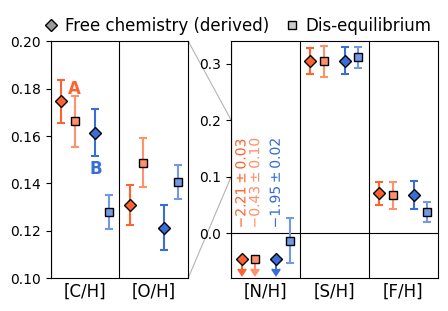

In [79]:
def plot_metallicity(ax, x, abs_abund, log_g_norm_factor, species, fmt='s', ms=6, mec='k', color=color_A, zorder=10, elinewidth=1.5, capsize=3, capthick=1.5, **kwargs):
    
    for x_i, species_i in zip(x, species):
        if species_i not in abs_abund:
            continue
        post = np.log10(10**abs_abund[species_i]*log_g_norm_factor)
        y = np.median(post)
        yerr = np.std(post)
        if y > ax.get_ylim()[1] or y < ax.get_ylim()[0]:
            yerr = 0.04
            if y < ax.get_ylim()[0]:
                y = 0.08; uplims = True; lolims = False
            else:
                y = 0.92; lolims = True; uplims = False
            ax.errorbar(
                x_i, y, yerr=yerr, transform=ax.get_xaxis_transform(), 
                lolims=lolims, uplims=uplims,
                fmt=fmt, ms=ms, mec=mec, color=color, zorder=zorder, elinewidth=elinewidth,
                capsize=capsize, capthick=capthick, **kwargs
            )
            ax.annotate(
                r'$'+f'{np.median(post):.2f}\pm{np.std(post):.2f}'+r'$', xy=(x_i, y+0.13), 
                rotation=90, ha='center', va='bottom', xycoords=ax.get_xaxis_transform(), 
                fontsize=10, color=color, path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.9)],
            )
            continue

        ax.errorbar(
            x_i, y, yerr=np.std(post), fmt=fmt, ms=ms, mec=mec,
            color=color, zorder=zorder, elinewidth=elinewidth, capsize=capsize, 
            capthick=capthick, **kwargs
        )

fig, ax = plt.subplots(figsize=(4.5,3.0), ncols=2, gridspec_kw={'width_ratios':[2,3], 'wspace':0.25})

x = np.array([0.5,1.5]); species = ['C/H', 'O/H']
ax[0].set(xlim=(0,2), ylim=(0.10,0.20))
ax[0].set_xticks(x, ['[C/H]','[O/H]'], fontsize=12)
plot_metallicity(ax[0], x-0.25-0.1, abs_abund_A, log_g_norm_factor_A, species=species, color=color_A, fmt='D')
plot_metallicity(ax[0], x+0.25-0.1, abs_abund_B, log_g_norm_factor_B, species=species, color=color_B, fmt='D')
plot_metallicity(ax[0], x-0.25+0.1, abs_abund_A_eq, log_g_norm_factor_A_eq, species=species, color=color_A_eq)
plot_metallicity(ax[0], x+0.25+0.1, abs_abund_B_eq, log_g_norm_factor_B_eq, species=species, color=color_B_eq)

x = np.array([0.5,1.5,2.5]); species = ['N/H', 'S/H', 'F/H']
ax[1].set(xlim=(0,3), ylim=(-0.08,0.34))
ax[1].set_xticks(x, ['[N/H]','[S/H]','[F/H]'], fontsize=12)
plot_metallicity(ax[1], x-0.25-0.1, abs_abund_A, log_g_norm_factor_A, species=species, color=color_A, fmt='D')
plot_metallicity(ax[1], x+0.25-0.1, abs_abund_B, log_g_norm_factor_B, species=species, color=color_B, fmt='D')
plot_metallicity(ax[1], x-0.25+0.1, abs_abund_A_eq, log_g_norm_factor_A_eq, species=species, color=color_A_eq)
plot_metallicity(ax[1], x+0.25+0.1, abs_abund_B_eq, log_g_norm_factor_B_eq, species=species, color=color_B_eq)

[ax[0].axvline(x_i-0.5, color='k', lw=0.8, zorder=-20) for x_i in [0.5,1.5]]
ax[0].axhline(0., color='k', lw=0.8, ls='-', zorder=-20)
[ax[1].axvline(x_i-0.5, color='k', lw=0.8, zorder=-20) for x_i in [0.5,1.5,2.5]]
ax[1].axhline(0., color='k', lw=0.8, ls='-', zorder=-20)

from matplotlib.patches import ConnectionPatch
kwargs = dict(coordsA=ax[0].get_yaxis_transform(), coordsB=ax[1].get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)
con = ConnectionPatch(xyA=(1, ax[0].get_ylim()[0]), xyB=(0, ax[0].get_ylim()[0]), **kwargs); ax[0].add_artist(con)
con = ConnectionPatch(xyA=(1, ax[0].get_ylim()[1]), xyB=(0, ax[0].get_ylim()[1]), **kwargs); ax[0].add_artist(con)

ax[0].annotate('A', xy=(0.25+0.1,0.18), fontsize=12, color=color_A, fontweight='bold', ha='center', va='center')
ax[0].annotate('B', xy=(0.75-0.1,0.146), fontsize=12, color=color_B, fontweight='bold', ha='center', va='center')

ax[1].plot(np.nan, np.nan, marker='D', ms=6, mec='k', color='0.6', label='Free chemistry (derived)')
ax[1].plot(np.nan, np.nan, marker='s', ms=6, mec='k', color='0.8', label='Dis-equilibrium')
ax[1].legend(
    loc='lower center', bbox_to_anchor=(0.05,1.0), handlelength=0., frameon=False, borderaxespad=0., prop={'size':12}, ncols=2, columnspacing=1.4
)

ax[0].tick_params(axis='x', which='both', length=0)
ax[1].tick_params(axis='x', which='both', length=0)

plt.subplots_adjust(left=0.11, bottom=0.10, top=0.89, right=0.97)
plt.savefig('./plots/K_band_abs_abund.pdf')
plt.show()

In [89]:
result_utils.latex_format(
    abs_abund_A['C/H']*log_g_norm_factor_A, q=result_utils.q[[-1,0]], decimals=2
    )

$0.17^{+0.02}_{-0.03}$ \\


$5.0^{+3.9}_{-2.0}$ & $1.5^{+0.5}_{-0.3}$ \\


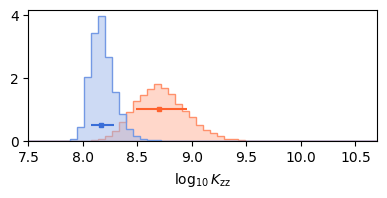

In [14]:
log_Kzz_A_eq = A_eq.posterior[:,A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]
log_Kzz_B_eq = B_eq.posterior[:,B_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]

result_utils.latex_format(10**log_Kzz_A_eq/1e8, 10**log_Kzz_B_eq/1e8, decimals=1)

bins = 50; hist_range = [7.50,10.70]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(log_Kzz_A_eq, label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq)
ax.hist(log_Kzz_B_eq, label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq)
# ax.hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
plot_errorbar(ax, log_Kzz_A_eq, y=0.24, q=result_utils.q[[2,4]], color=color_A)
plot_errorbar(ax, log_Kzz_B_eq, y=0.12, q=result_utils.q[[2,4]], color=color_B)
ax.set(xlim=hist_range, xlabel=r'$\log_{10} K_\mathrm{zz}$')
plt.show()

5.573680964005903e-06
1.0904750205648333e-05
1881.8946199420018
1759.359917023731


/var/tmp/regt/ipykernel_2749559/2556064025.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
/var/tmp/regt/ipykernel_2749559/2922475653.py:395: RuntimeWarning: overflow encountered in power
  x=np.quantile(10**log_t_NH3_A_eq, result_utils.q, axis=0),
/net/lem/data2/regt/conda_pRT3_env/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/tmp/regt/ipykernel_2749559/2922475653.py:401: RuntimeWarning: overflow encountered in power
  x=np.quantile(10**log_t_NH3_B_eq, result_utils.q, axis=0),


1069.7114503458397
6187.366405078503


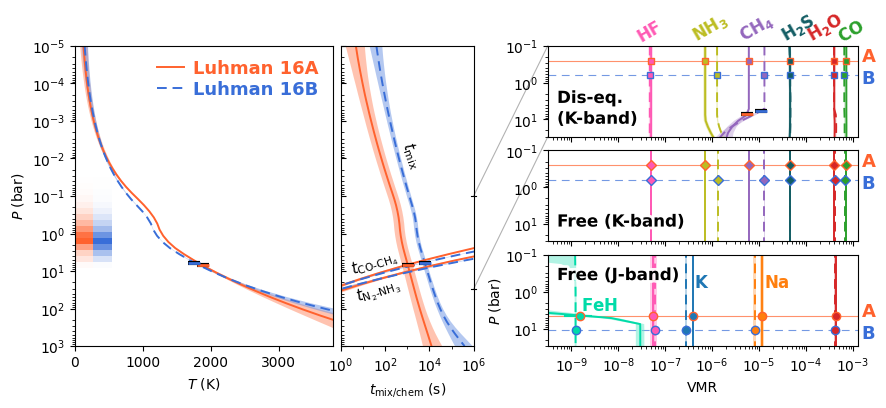

In [113]:
def plot_condensation_curve(ax, pressure, species, FeH=-0.0, ann_kwargs=None, **kwargs):

    coeffs = {
        'CaTiO3': [5.125, -0.277, -0.554], # Wakeford et al. (2017)
        'Fe': [5.44, -0.48, -0.48], # Visscher et al. (2010)
        'Mg2SiO4': [5.89, -0.37, -0.73], # Visscher et al. (2010)
        'MgSiO3': [6.26, -0.35, -0.70], # Visscher et al. (2010)
        'Cr': [6.576, -0.486, -0.486], # Morley et al. (2012)
        'KCl': [12.479, -0.879, -0.879], # Morley et al. (2012)
        'MnS': [7.45, -0.42, -0.84], # Visscher et al. (2006)
        'Na2S': [10.05, -0.72, -1.08], # Visscher et al. (2006)
        'ZnS': [12.52, -0.63, -1.26], # Visscher et al. (2006)
        'H2S': [86.49, -8.54, -8.54], # Visscher et al. (2006)
    }

    a, b, c = coeffs[species]
    y = a + b*np.log10(pressure) + c*FeH
    T = 1e4/y
    
    ax.plot(T, pressure, **kwargs, zorder=-2)

    if ann_kwargs is None:
        return
    
    y = ann_kwargs.get('y', 1e0)
    ann_kwargs['xy'] = (np.interp(np.log10(y),np.log10(pressure),T), y)
    ann_kwargs.pop('y')

    ax.annotate(**ann_kwargs, zorder=-1)

log_g_norm_factor_A = 10**(4.96-log_g_A)
log_g_norm_factor_B = 10**(4.88-log_g_B)
log_g_norm_factor_A_eq = 10**(4.96-log_g_A_eq)
log_g_norm_factor_B_eq = 10**(4.88-log_g_B_eq)
log_g_norm_factor_A_J = 10**(4.96-log_g_A_J)
log_g_norm_factor_B_J = 10**(4.88-log_g_B_J)

contr_A_eq = A_eq.get_contribution_function()
contr_B_eq = B_eq.get_contribution_function()

A.load_components(['PT']); B.load_components(['PT'])
A_eq.load_components(['PT']); B_eq.load_components(['PT'])
A_J.load_components(['PT']); B_J.load_components(['PT'])

y_A = 10**(np.log10(0.4)-0.2)
y_B = 10**(np.log10(0.4)+0.2)

# xlim_VMR = (10**(-7.7), 10**(-2.8))
xlim_VMR = (10**(-9.5), 10**(-2.9))
ylim_VMR = (30,0.1)

fig = plt.figure(figsize=(9,3.9))
gs = fig.add_gridspec(
    # ncols=5, nrows=4, hspace=0.15, wspace=0.05, width_ratios=[0.05,0.23,0.18,0.09,0.47], height_ratios=[0.15,1,1,1], 
    ncols=5, nrows=3, hspace=0.15, wspace=0.05, width_ratios=[0.05,0.29,0.18,0.08,0.42], height_ratios=[1,1,1], 
    )

ax_contr = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,:2])
ax_VMR = fig.add_subplot(gs[:,2])

# ax_eq = fig.add_subplot(gs[1,-1])
# ax_fc = fig.add_subplot(gs[2,-1])
# ax_J = fig.add_subplot(gs[3,-1])
ax_eq = fig.add_subplot(gs[0,-1])
ax_fc = fig.add_subplot(gs[1,-1])
ax_J = fig.add_subplot(gs[2,-1])

# --- PT profiles --------------------------------------
ax_contr.imshow(
    contr_A_eq['K2166_1'].reshape(-1,1), cmap=cmap_A, aspect='auto', interpolation='none', 
    extent=[0,0.5,0,1], transform=ax_contr.transAxes, 
)
ax_contr.imshow(
    contr_B_eq['K2166_1'].reshape(-1,1), cmap=cmap_B, aspect='auto', interpolation='none', 
    extent=[0.5,1,0,1], transform=ax_contr.transAxes, 
)
ax_contr.set_axis_off()
ax_contr.set(yticks=[], xticks=[])

# --- PT profiles --------------------------------------
ax_ins = ax_PT.inset_axes(bounds=(0.44,0.43,0.52,0.36), transform=ax_PT.transAxes)
ax_ins.set_xticks(np.arange(1000,2001,100), minor=True)
ax_ins.set_xticks([1500,1700,1900])
# ax_ins.set(yscale='log', xlim=(900,1600), ylim=(5e0,8e-2), yticklabels=[])
ax_ins.set(yscale='log', xlim=(1600,2000), ylim=(2e1,1e0), yticklabels=[])
# _, connectors = ax_PT.indicate_inset_zoom(ax_ins, ec='k', lw=0.8, alpha=0.3)
# connectors[0].set_visible(False)
# connectors[1].set_visible(True)
# connectors[2].set_visible(True)
# connectors[3].set_visible(False)
ax_ins.set_visible(False); ax_ins = None

for ax_i in [ax_PT, ax_ins]:
    if ax_i is None:
        continue
    temperature_q = result_utils.profile_quantiles(A_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, A_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4), 
        **dict(fc=env_colors_A[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
        )
    temperature_q = result_utils.profile_quantiles(B_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, B_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
        **dict(fc=env_colors_B[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
        )
    
    # if ax_i == ax_PT:
    #     continue

    # temperature_q = result_utils.profile_quantiles(A_J.PT['J1226_1'].temperature_posterior)
    # ax_i.plot(temperature_q[3], A_J.Chem['J1226_1'].pressure, c=color_A, lw=0.8, zorder=5, path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])
    # temperature_q = result_utils.profile_quantiles(B_J.PT['J1226_1'].temperature_posterior)
    # ax_i.plot(temperature_q[3], B_J.Chem['J1226_1'].pressure, c=color_B, lw=0.8, zorder=5, path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])

    # temperature_q = result_utils.profile_quantiles(A.PT['K2166_1'].temperature_posterior)
    # ax_i.plot(temperature_q[3], A.Chem['K2166_1'].pressure, c=color_A, lw=0.8, zorder=5, path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])
    # temperature_q = result_utils.profile_quantiles(B.PT['K2166_1'].temperature_posterior)
    # ax_i.plot(temperature_q[3], B.Chem['K2166_1'].pressure, c=color_B, lw=0.8, zorder=5, path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])
    

handle_A, = ax_PT.plot(np.nan, np.nan, color=color_A, lw=1.4, label='Luhman 16A')
handle_B, = ax_PT.plot(np.nan, np.nan, color=color_B, lw=1.4, ls=(0,(5,3)), label='Luhman 16B')
ax_PT.legend(
    loc='upper right', bbox_to_anchor=(0.97,0.98), frameon=False, 
    handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderaxespad=0.0, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)
ax_PT.set(
    xlim=(0,3800), xlabel=r'$T$ (K)', #xticks=[0,1000,2000,3000],
    yscale='log', ylim=(1e3, 1e-5), facecolor='none', ylabel=r'$P$ (bar)',
)

# --- VMR profiles -------------------------------------
species_info = {
    '12CO': ('C2', 'CO', (+0.15,0)), 
    'H2O': ('C3', 'H_2O', (-0.15,0)),
    'CH4': ('C4', 'CH_4', (0,0)),
    'NH3': ('C8', 'NH_3', (0,0)),
    'H2S': ('#135D64', 'H_2S', (+0.2,0)),
    'HF': ('#FF59B4', 'HF', (0,0)),
}
for species, (c, l, xy) in species_info.items():
    l = r'$\mathrm{\bf '+f'{l}'+'}$'
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    '''
    plot_VMR_envelope(
        ax_VMR, A_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_A_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_VMR_envelope(
        ax_VMR, B_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_B_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    '''

    x = np.mean([np.median(abs_abund_A_eq[species]), np.median(abs_abund_B_eq[species])])
    x = 10**(np.log10(x)+xy[0])
    y = 1 + xy[1]
    ax_eq.annotate(
        l, xy=(x,y), xycoords=ax_eq.get_xaxis_transform(), ha='center', va='bottom', fontsize=12, c=c, rotation=30, 
        )
    
ax_VMR.tick_params(axis='y', which='both', direction='in')
ax_VMR.set(
    xscale='log', xlim=(10**(-7.7),xlim_VMR[1]), xlabel='VMR', yscale='log', ylim=(1e3, 1e-5), yticklabels=[], 
    )

def add_quench_marker(ax, pressure, Pquench, x, type='linear', **kwargs):
    if ax is None:
        return
    
    # interpolate x value at Pquench
    if type == 'log':
        x_quench = 10**np.interp(np.log10(Pquench), np.log10(pressure), np.log10(x))
    else:
        x_quench = np.interp(np.log10(Pquench), np.log10(pressure), x)


    print(x_quench)

    # draw a slightly larger black marker underneath to act as a border
    border_kwargs = kwargs.copy()
    # increase marker size and edge width for the border
    border_kwargs['ms'] = kwargs.get('ms', 7) + 1
    border_kwargs['mew'] = kwargs.get('mew', 1.4) + 1.0
    border_kwargs['c'] = 'k'
    border_kwargs['mec'] = 'k'
    # place border below main marker
    border_kwargs['zorder'] = kwargs.get('zorder', 20) - 1
    ax.plot(x_quench, Pquench, **border_kwargs)

    # draw main marker on top
    main_kwargs = kwargs.copy()
    main_kwargs['zorder'] = kwargs.get('zorder', 20)
    ax.plot(x_quench, Pquench, **main_kwargs)

# add_quench_marker(
#     ax_VMR, A_eq.Chem['K2166_1'].pressure, np.median(A_eq_P_quench_posterior['CO_CH4']), 
#     np.median(A_eq.Chem['K2166_1'].VMRs_posterior['CH4']*log_g_norm_factor_A_eq[:,None], axis=0), mew=1.4, ms=7, marker='_', c=color_A, zorder=20, 
#     )
# add_quench_marker(
#     ax_VMR, B_eq.Chem['K2166_1'].pressure, np.median(B_eq_P_quench_posterior['CO_CH4']), 
#     np.median(B_eq.Chem['K2166_1'].VMRs_posterior['CH4']*log_g_norm_factor_B_eq[:,None], axis=0), mew=1.4, ms=7, marker='_', c=color_B, zorder=22, 
#     )
add_quench_marker(
    ax_eq, A_eq.Chem['K2166_1'].pressure, np.median(A_eq_P_quench_posterior['CO_CH4']), 
    np.median(A_eq.Chem['K2166_1'].VMRs_posterior['CH4']*log_g_norm_factor_A_eq[:,None], axis=0), mew=2.0, ms=8, marker='_', c=color_A, zorder=20, 
    )
add_quench_marker(
    ax_eq, B_eq.Chem['K2166_1'].pressure, np.median(B_eq_P_quench_posterior['CO_CH4']), 
    np.median(B_eq.Chem['K2166_1'].VMRs_posterior['CH4']*log_g_norm_factor_B_eq[:,None], axis=0), mew=2.0, ms=8, marker='_', c=color_B, zorder=22, 
    )

# add_quench_marker(
#     ax_eq, A_eq.Chem['K2166_1'].pressure, np.median(A_eq_P_quench_posterior['N2_NH3']), 
#     np.median(A_eq.Chem['K2166_1'].VMRs_posterior['NH3']*log_g_norm_factor_A_eq[:,None], axis=0), mew=1.4, ms=7, marker='_', c=color_A, zorder=20, 
#     )
# add_quench_marker(
#     ax_eq, B_eq.Chem['K2166_1'].pressure, np.median(B_eq_P_quench_posterior['N2_NH3']), 
#     np.median(B_eq.Chem['K2166_1'].VMRs_posterior['NH3']*log_g_norm_factor_B_eq[:,None], axis=0), mew=1.4, ms=7, marker='_', c=color_B, zorder=22, 
#     )

add_quench_marker(
    ax_PT, A_eq.PT['K2166_1'].pressure, np.median(A_eq_P_quench_posterior['CO_CH4']), 
    np.median(A_eq.PT['K2166_1'].temperature_posterior, axis=0), mew=2.0, ms=8, marker='_', c=color_A, zorder=20, 
    )
add_quench_marker(
    ax_PT, B_eq.PT['K2166_1'].pressure, np.median(B_eq_P_quench_posterior['CO_CH4']), 
    np.median(B_eq.PT['K2166_1'].temperature_posterior, axis=0), mew=2.0, ms=8, marker='_', c=color_B, zorder=22,
    )

add_quench_marker(
    ax_ins, A_eq.PT['K2166_1'].pressure, np.median(A_eq_P_quench_posterior['CO_CH4']), 
    np.median(A_eq.PT['K2166_1'].temperature_posterior, axis=0), mew=2.0, ms=8, marker='_', c=color_A, zorder=20, 
    )
add_quench_marker(
    ax_ins, B_eq.PT['K2166_1'].pressure, np.median(B_eq_P_quench_posterior['CO_CH4']), 
    np.median(B_eq.PT['K2166_1'].temperature_posterior, axis=0), mew=2.0, ms=8, marker='_', c=color_B, zorder=22,
    )

# --- VMR at photosphere -------------------------------
for i, ax_i in enumerate([ax_eq, ax_fc, ax_J]):
    ax_i.set(yscale='log', ylim=ylim_VMR)
    ax_i.set(xscale='log', xlim=xlim_VMR, xlabel='VMR')
    if i != 2:
        ax_i.set_xticklabels([])
        # ax_i.set_yticklabels([])
        ax_i.set_xlabel('')
    else:
        ax_i.set_ylabel(r'$P$ (bar)', labelpad=1)

    # ax_i.set_yticks([1e1,1e0,1e-1]); ax_i.set_yticklabels([r'$10$', r'$1$', r'$0.1$'])
    ax_i.set_yticks([1e1,1e0,1e-1]); ax_i.set_yticklabels([r'$10^1$', r'$10^0$', r'$10^{-1}$'])

ann_kwargs = dict(
    xycoords='axes fraction', fontsize=12, c='k', fontweight='bold',
    path_effects=[pe.withStroke(linewidth=4, foreground='w', alpha=0.9)],
)
ax_eq.annotate('Dis-eq.\n(K-band)', ha='left', va='bottom', xy=(0.03,0.1), **ann_kwargs)
ax_fc.annotate('Free (K-band)', ha='left', va='bottom', xy=(0.03,0.12), **ann_kwargs)
ax_J.annotate('Free (J-band)', ha='left', va='top', xy=(0.03,0.88), **ann_kwargs)

from matplotlib.patches import ConnectionPatch
kwargs = dict(coordsA=ax_VMR.get_yaxis_transform(), coordsB=ax_eq.get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)
con = ConnectionPatch(xyA=(1, ylim_VMR[1]), xyB=(0, ylim_VMR[1]), **kwargs); ax_VMR.add_artist(con)
con = ConnectionPatch(xyA=(1, ylim_VMR[0]), xyB=(0, ylim_VMR[0]), **kwargs); ax_VMR.add_artist(con)
ax_VMR.plot([0.98,1.02], [ylim_VMR[1],ylim_VMR[1]], transform=ax_VMR.get_yaxis_transform(), color='k', lw=0.8, clip_on=False)
ax_VMR.plot([0.98,1.02], [ylim_VMR[0],ylim_VMR[0]], transform=ax_VMR.get_yaxis_transform(), color='k', lw=0.8, clip_on=False)
# ax_VMR.plot([1, 1], [1e-1, 15], transform=ax_VMR.get_yaxis_transform(), lw=1.6, c='k', clip_on=False)
# ax_VMR.plot([0,1,1,0], [ylim_VMR[1],ylim_VMR[1],ylim_VMR[0],ylim_VMR[0]], transform=ax_VMR.get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)

for species, (c, l, xy) in species_info.items():
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    plot_VMR_envelope(
        ax_eq, A_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_A_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5), 
        )
    plot_errorbar(
        ax_eq, abs_abund_A_eq[species]*log_g_norm_factor_A_eq, y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_eq.transData, ms=5, mec=color_A
        )

    plot_VMR_envelope(
        ax_fc, A.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_A[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_fc, abs_abund_A[species]*log_g_norm_factor_A, y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_fc.transData, marker='D', ms=5, mec=color_A
        )
    
    plot_VMR_envelope(
        ax_eq, B_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_B_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_eq, abs_abund_B_eq[species]*log_g_norm_factor_B_eq, y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_eq.transData, ms=5, mec=color_B
        )

    plot_VMR_envelope(
        ax_fc, B.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_B[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_fc, abs_abund_B[species]*log_g_norm_factor_B, y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_fc.transData, marker='D', ms=5, mec=color_B
        )
    
species_info = {
    'H2O': ('C3', 'H_2O', (-0.2,0)),
    'HF': ('#FF59B4', 'HF', (0,-0.44)),
    'Na': ('C1', 'Na', (0,0)), 
    'K': ('C0', 'K', (0,0)),
    'FeH': ('#00DBA8', 'FeH', (0,0)),
}
for species, (c, l, xy) in species_info.items():
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    log_g_norm_factor = 10**(4.96-log_g_A_J)
    plot_VMR_envelope(
        ax_J, A_J.Chem['J1226_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_J, abs_abund_A_J[species]*log_g_norm_factor, y=10**(np.log10(7.)-0.2), q=result_utils.q[[2,4]], color=c, transform=ax_J.transData, marker='o', ms=6, mec=color_A
        )
        
    log_g_norm_factor = 10**(4.88-log_g_B_J)
    plot_VMR_envelope(
        ax_J, B_J.Chem['J1226_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_J, abs_abund_B_J[species]*log_g_norm_factor, y=10**(np.log10(7.)+0.2), q=result_utils.q[[2,4]], color=c, transform=ax_J.transData, marker='o', ms=6, mec=color_B
        )

ax_J.annotate(
    r'$\mathrm{\bf FeH}$', xy=(10**(-8.4),0.35), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['FeH'][0], rotation=0, 
    )
ax_J.annotate(
    r'$\mathrm{\bf K}$', xy=(10**(-6.23),0.6), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['K'][0], rotation=0, 
    )
ax_J.annotate(
    r'$\mathrm{\bf Na}$', xy=(10**(-4.62),0.6), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['Na'][0], rotation=0, 
    )

for ax_i, y_cen in zip([ax_eq, ax_fc, ax_J], [0.4,0.4,7.0]):
    ax_i.annotate(
        r'$\mathrm{\bf A}$', xy=(1.01, 10**(np.log10(y_cen)-0.3)), xycoords=ax_i.get_yaxis_transform(), 
        ha='left', va='center', fontsize=13, c=color_A,
        )
    ax_i.annotate(
        r'$\mathrm{\bf B}$', xy=(1.01, 10**(np.log10(y_cen)+0.3)), xycoords=ax_i.get_yaxis_transform(), 
        ha='left', va='center', fontsize=13, c=color_B,
        )
    
    kwargs = dict(lw=0.8, c=color_A, zorder=-1, alpha=0.7)
    ax_i.plot([0.,1.0], [10**(np.log10(y_cen)-0.2)]*2, transform=ax_i.get_yaxis_transform(), **kwargs)
    kwargs['ls'] = (0,(7,5)); kwargs['c'] = color_B
    ax_i.plot([0.,1.0], [10**(np.log10(y_cen)+0.2)]*2, transform=ax_i.get_yaxis_transform(), **kwargs)

ax_t = ax_VMR
# ax_t = ax_VMR.twiny()
plot_envelopes(
    ax_t, A_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_mix_A_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_A, lw=1.4), 
    **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
    )
plot_envelopes(
    ax_t, B_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_mix_B_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
    **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
    )

plot_envelopes(
    ax_t, A_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_CO_CH4_A_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_A, lw=1.4), 
    **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
    )
plot_envelopes(
    ax_t, B_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_CO_CH4_B_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
    **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
    )

plot_envelopes(
    ax_t, A_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_NH3_A_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_A, lw=1.4), 
    **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
    )
plot_envelopes(
    ax_t, B_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_NH3_B_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
    **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
    )

ax_t.annotate(
    r'$t_{\rm CO'+u'\u2010'+'CH_4}$', xy=(0.06,0.24), xycoords='axes fraction', fontsize=11, rotation=18, 
    )
ax_t.annotate(
    r'$t_{\rm N_2'+u'\u2010'+'NH_3}$', xy=(0.10,0.15), xycoords='axes fraction', fontsize=11, rotation=18, 
    )
ax_t.annotate(
    r'$t_{\rm mix}$', xy=(0.43,0.6), xycoords='axes fraction', fontsize=11, rotation=-70, 
    )

add_quench_marker(
    ax_t, A_eq.PT['K2166_1'].pressure, np.median(A_eq_P_quench_posterior['CO_CH4']), 
    10**np.median(log_t_mix_A_eq, axis=0), mew=2.0, ms=8, marker='_', c=color_A, zorder=20, 
    )
add_quench_marker(
    ax_t, B_eq.PT['K2166_1'].pressure, np.median(B_eq_P_quench_posterior['CO_CH4']), 
    10**np.median(log_t_mix_B_eq, axis=0), mew=2.0, ms=8, marker='_', c=color_B, zorder=22,
    )

ax_t.set(xscale='log', xlim=(1e0,1e6), xlabel=r'$t_\mathrm{mix/chem}$ (s)')
ax_t.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5], minor=True, labels=[])


plt.subplots_adjust(left=0.09, bottom=0.13, top=0.9, right=0.96)
plt.savefig('./plots/K_band_VMR_profiles.pdf')
plt.show()

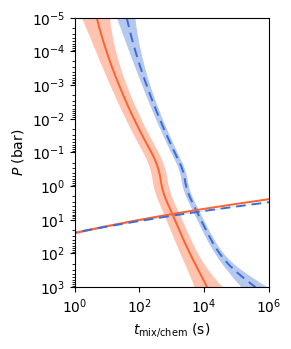

In [97]:
def get_t_mix_posterior(pressure, FeH_posterior, temperature_posterior, MMW_posterior, log_g_posterior, log_Kzz_chem_posterior, alpha=1.0):
    """Calculate mixing time-scale posterior given a mixing length parameter alpha."""
    from retrieval_base.utils import sc

    pressure = pressure[None,:]
    
    FeH_posterior = FeH_posterior[:,None]
    log_g_posterior = log_g_posterior[:,None]
    log_Kzz_chem_posterior = log_Kzz_chem_posterior[:,None]

    m = 10**FeH_posterior

    # Scale height at each layer
    kB  = sc.k * 1e7
    amu = sc.amu * 1e3  # Convert to cgs (g)
    H = kB*temperature_posterior / (MMW_posterior*amu * 10**log_g_posterior)

    # Mixing length/time-scales
    L = alpha * H
    t_mix = L**2 / 10**log_Kzz_chem_posterior

    inv_t_q1 = 1.0e6/1.5 * pressure * m**0.7 * np.exp(-42000/temperature_posterior)
    inv_t_q2 = 1/40 * pressure**2 * np.exp(-25000/temperature_posterior)
    log_t_CO_CH4 = -1 * np.log10(inv_t_q1 + inv_t_q2)

    log_t_NH3 = -7.0 - np.log10(pressure) + 52000/temperature_posterior*np.log10(np.e)

    return np.log10(t_mix), log_t_CO_CH4, log_t_NH3

A_eq.load_components(['Chem', 'PT'])
MMW_posterior = np.zeros_like(A_eq.PT['K2166_1'].temperature_posterior)
for species_i, VMR_i in A_eq.Chem['K2166_1'].VMRs_posterior.items():
    mass_i = A_eq.Chem['K2166_1'].read_species_info(species_i, 'mass')
    MMW_posterior += mass_i * VMR_i

idx_CH = A_eq.ParamTable.get('alpha_C', key='idx_free')
idx_log_Kzz_chem = A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')
idx_log_g = A_eq.ParamTable.get('log_g', key='idx_free')

log_t_mix_A_eq, log_t_CO_CH4_A_eq, log_t_NH3_A_eq = get_t_mix_posterior(
    A_eq.Chem['K2166_1'].pressure, 
    FeH_posterior=A_eq.posterior[:,idx_CH], 
    temperature_posterior=A_eq.PT['K2166_1'].temperature_posterior,
    MMW_posterior=MMW_posterior,
    log_g_posterior=A_eq.posterior[:,idx_log_g],
    log_Kzz_chem_posterior=A_eq.posterior[:,idx_log_Kzz_chem],
    )

B_eq.load_components(['Chem', 'PT'])
MMW_posterior = np.zeros_like(B_eq.PT['K2166_1'].temperature_posterior)
for species_i, VMR_i in B_eq.Chem['K2166_1'].VMRs_posterior.items():
    mass_i = B_eq.Chem['K2166_1'].read_species_info(species_i, 'mass')
    MMW_posterior += mass_i * VMR_i
    
log_t_mix_B_eq, log_t_CO_CH4_B_eq, log_t_NH3_B_eq = get_t_mix_posterior(
    B_eq.Chem['K2166_1'].pressure,
    FeH_posterior=B_eq.posterior[:,idx_CH],
    temperature_posterior=B_eq.PT['K2166_1'].temperature_posterior,
    MMW_posterior=MMW_posterior,
    log_g_posterior=B_eq.posterior[:,idx_log_g],
    log_Kzz_chem_posterior=B_eq.posterior[:,idx_log_Kzz_chem],
    )

fig, ax = plt.subplots(figsize=(2.5,3.5))
plot_envelopes(
    ax, A_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_mix_A_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_A, lw=1.4), 
    **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
    )
plot_envelopes(
    ax, B_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_mix_B_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
    **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
    )

plot_envelopes(
    ax, A_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_CO_CH4_A_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_A, lw=1.4), 
    **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
    )
plot_envelopes(
    ax, B_eq.Chem['K2166_1'].pressure, 
    x=np.quantile(10**log_t_CO_CH4_B_eq, result_utils.q, axis=0), 
    median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
    **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
    )

# ax.plot(10**log_t_mix_A_eq, A_eq.Chem['K2166_1'].pressure, c=color_A, lw=1.4)
# ax.plot(10**log_t_mix_B_eq, B_eq.Chem['K2166_1'].pressure, c=color_B, lw=1.4, ls=(0,(5,3)))

# ax.plot(10**log_t_CO_CH4_A_eq, A_eq.Chem['K2166_1'].pressure, c='k', lw=0.8, ls=':')
# ax.plot(10**log_t_CO_CH4_B_eq, B_eq.Chem['K2166_1'].pressure, c=color_B, lw=0.8, ls=':')

# ax.plot(10**log_t_NH3_A_eq, A_eq.Chem['K2166_1'].pressure, c='k', lw=0.8, ls='--')
# ax.plot(10**log_t_NH3_B_eq, B_eq.Chem['K2166_1'].pressure, c=color_B, lw=0.8, ls='--')

ax.set(xscale='log', yscale='log', xlabel=r'$t_\mathrm{mix/chem}$ (s)', ylabel=r'$P$ (bar)', ylim=(1e3,1e-5), xlim=(1e-8,1e21))
ax.set_xlim(1e0,1e6)
plt.show()

In [135]:
# Pquench = 7; Tquench = np.linspace(1000,3000,50)
Pquench = 7; Tquench = 1800
inv_t_q1 = 1.0e6/1.5 * Pquench * 1**0.7 * np.exp(-42000/Tquench)
inv_t_q2 = 1/40 * Pquench**2 * np.exp(-25000/Tquench)
t_CO_CH4 = 1/(inv_t_q1 + inv_t_q2)

Kzz = Tquench**2 / t_CO_CH4
print(Kzz)

# plt.plot(Kzz, 10**np.linspace(-5,3,50))

# Pquench = 10**np.linspace(-5,3,50); Tquench = 1700
Pquench = 7; Tquench = 1400
inv_t_q1 = 1.0e6/1.5 * Pquench * 1**0.7 * np.exp(-42000/Tquench)
inv_t_q2 = 1/40 * Pquench**2 * np.exp(-25000/Tquench)
t_CO_CH4 = 1/(inv_t_q1 + inv_t_q2)

Kzz = Tquench**2 / t_CO_CH4
print(Kzz)

# plt.plot(Kzz, 10**np.linspace(-5,3,50))
# plt.xscale('log'); plt.yscale('log')
# plt.show()

1115.455448965845
0.8980932012702633


In [127]:
250/0.89

280.8988764044944

In [96]:
from tqdm import tqdm

A_eq._load_initial_components()

A_eq.Chem['K2166_1'].abundance_file = '/net/lem/data1/regt/fastchem/input/element_abundances/asplund_2020_simplified.dat'
A_eq.Chem['K2166_1'].gas_data_file  = '/net/lem/data1/regt/fastchem/input/logK/logK_simplified.dat'
A_eq.Chem['K2166_1'].cond_data_file = '/net/lem/data1/regt/fastchem/input/logK/logK_condensates_simplified.dat'

A_eq.Chem['K2166_1']._get_fastchem_object()
A_eq.Chem['K2166_1'].gas_species_tot = A_eq.Chem['K2166_1'].fastchem.getGasSpeciesNumber()
A_eq.Chem['K2166_1']._get_element_indices()
A_eq.Chem['K2166_1']._get_solar()

B_eq._load_initial_components()

B_eq.Chem['K2166_1'].abundance_file = '/net/lem/data1/regt/fastchem/input/element_abundances/asplund_2020_simplified.dat'
B_eq.Chem['K2166_1'].gas_data_file  = '/net/lem/data1/regt/fastchem/input/logK/logK_simplified.dat'
B_eq.Chem['K2166_1'].cond_data_file = '/net/lem/data1/regt/fastchem/input/logK/logK_condensates_simplified.dat'

B_eq.Chem['K2166_1']._get_fastchem_object()
B_eq.Chem['K2166_1'].gas_species_tot = B_eq.Chem['K2166_1'].fastchem.getGasSpeciesNumber()
B_eq.Chem['K2166_1']._get_element_indices()
B_eq.Chem['K2166_1']._get_solar()


A_eq_P_quench_posterior = {
    key: [] for key in A_eq.Chem['K2166_1'].quench_settings.keys()
}
B_eq_P_quench_posterior = {
    key: [] for key in B_eq.Chem['K2166_1'].quench_settings.keys()
}
np.random.seed(1848172)
# idx = np.random.randint(0, len(A_eq.posterior), size=500)
# for post_i in tqdm(A_eq.posterior[idx]):
for post_i in tqdm(A_eq.posterior):
    A_eq._evaluate_sample(sample=post_i, evaluation=False, skip_radtrans=True)
    for key in A_eq_P_quench_posterior.keys():
        A_eq_P_quench_posterior[key].append(A_eq.Chem['K2166_1'].quench_settings[key][-1])

# idx = np.random.randint(0, len(B_eq.posterior), size=500)
# for post_i in tqdm(B_eq.posterior[idx]):
for post_i in tqdm(B_eq.posterior):
    B_eq._evaluate_sample(sample=post_i, evaluation=False, skip_radtrans=True)
    for key in B_eq_P_quench_posterior.keys():
        B_eq_P_quench_posterior[key].append(B_eq.Chem['K2166_1'].quench_settings[key][-1])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16978/16978 [21:09<00:00, 13.38it/s]


In [38]:
result_utils.latex_format(A_eq_P_quench_posterior['CO_CH4'], B_eq_P_quench_posterior['CO_CH4'], decimals=1)
result_utils.latex_format(np.log10(A_eq_P_quench_posterior['CO_CH4']), np.log10(B_eq_P_quench_posterior['CO_CH4']), decimals=2)

$7.1^{+1.0}_{-0.8}$ & $6.0^{+0.3}_{-0.2}$ \\
$0.85^{+0.06}_{-0.05}$ & $0.78^{+0.02}_{-0.02}$ \\


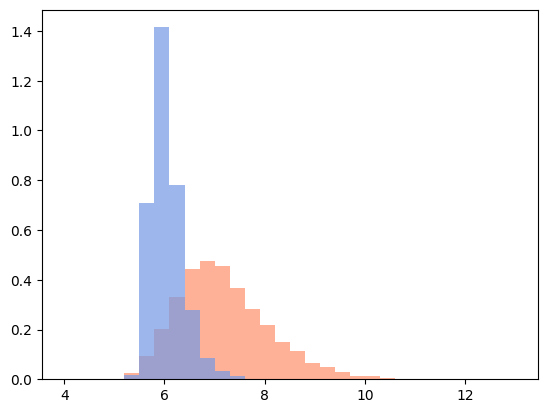

In [39]:
# plt.hist(np.log10(A_eq_P_quench_posterior['CO_CH4']), bins=30, range=(0.8,1.4), color=color_A_eq, alpha=0.7, density=True)
# plt.hist(np.log10(B_eq_P_quench_posterior['CO_CH4']), bins=30, range=(0.8,1.4), color=color_B_eq, alpha=0.7, density=True)
plt.hist(A_eq_P_quench_posterior['CO_CH4'], bins=30, range=(4,13), color=color_A_eq, alpha=0.7, density=True)
plt.hist(B_eq_P_quench_posterior['CO_CH4'], bins=30, range=(4,13), color=color_B_eq, alpha=0.7, density=True)
plt.show()